# Trends.Earth Global Data Processing

This notebook submits SDG 15.3.1 indicator jobs to the Trends.Earth API using a grid-based approach.
Each 60-degree grid cell contains multiple 15-degree sub-cells that are submitted together.

In [32]:
from __future__ import annotations

import json
import logging
import multiprocessing
import os
import re
import subprocess
import time
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from pathlib import Path
from typing import Dict, List, Optional, TypedDict
from zoneinfo import ZoneInfo

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from shapely.geometry import Polygon

load_dotenv()

from trendsearth_api import (  # noqa: E402
    TrendsEarthAPIClient,
    convert_subcells_to_geojson,
    get_tiff_files,
    print_job_details,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs)03d %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# Configuration - API_URL will be overridden by environment variable if set
API_URL = os.getenv("API_BASE_URL", "https://api.trends.earth")
LOCAL_TZ = ZoneInfo("America/New_York")
NUM_DAYS = 7  # Number of days to look back for jobs
DOWNLOAD_DIR = Path("C:/Data/TrendsEarth_Global_Data_Tiles")

# Define grid parameters
#  MAIN_CELL_SIZE = 60  # degrees - main grid cells
MAIN_CELL_SIZE = 45  # degrees - main grid cells
SUB_CELL_SIZE = 15  # degrees - sub-cells within each main grid cell
LON_MIN, LON_MAX = -180, 180
LAT_MIN, LAT_MAX = -90, 90

In [12]:
class TrendsEarthGridAPIClient(TrendsEarthAPIClient):
    """
    Extended API client with grid cell-specific functionality for global data processing.

    This class inherits from TrendsEarthAPIClient and adds methods specific to handling
    grid cell jobs, including filtering, geometry conversion, and grid-specific filename generation.
    """

    def _generate_base_filename(self, task_name: str, job_id: str) -> str:
        """
        Override base filename generation for grid cell-specific naming.

        Args:
            task_name: Task name from job params
            job_id: Job ID

        Returns:
            Base filename string with grid cell components
        """
        components = {
            "grid_cell": "unknown",
            "year_range": "2000-2023",
            "productivity_mode": "unknown",
            "base_name": "TrendsEarth_SDG15.3.1_2000_2023",
        }

        # Extract grid cell number: 60deg_cell_X_with
        grid_match = re.search(rf"{MAIN_CELL_SIZE}deg_cell_(\d+)_with", task_name)
        if grid_match:
            components["grid_cell"] = grid_match.group(1)

        # Extract productivity mode (last part after final underscore of subcells)
        mode_match = re.search(r"_subcells_(.+)$", task_name)
        if mode_match:
            components["productivity_mode"] = mode_match.group(1)

        # Extract year range if present in task name
        year_match = re.search(r"(\d{4})_(\d{4})", task_name)
        if year_match:
            components["year_range"] = f"{year_match.group(1)}_{year_match.group(2)}"
            components["base_name"] = (
                f"TrendsEarth_SDG15.3.1_{components['year_range']}"
            )

        return f"{components['base_name']}-{MAIN_CELL_SIZE}deg_cell-{components['grid_cell']}-{components['productivity_mode']}"

    def get_jobs_filtered_by_grid_cells(
        self, filter_name: str = None, days_back: int = 7, productivity_mode: str = None
    ) -> List[Dict]:
        """
        Get jobs from the API with grid cell filtering - returns only the most recent job for each grid cell.

        This function returns the most recent job (by start_date) for each grid cell and productivity mode
        combination, REGARDLESS OF STATUS (RUNNING, FINISHED, FAILED, etc.). If multiple jobs exist for the
        same grid cell and productivity mode, only the one with the latest start_date is returned.

        Args:
            filter_name: Filter jobs by this string in task name
            days_back: Number of days to look back (default: 7)
            productivity_mode: Filter by productivity mode ("TE", "FAO-WOCAT", "JRC"). REQUIRED - function fails if None.

        Returns:
            List of job dictionaries, filtered to most recent per grid cell and productivity mode (regardless of status)

        Raises:
            ValueError: If productivity_mode is None or not specified
        """
        # REQUIRED: productivity_mode must be specified
        if productivity_mode is None:
            raise ValueError(
                "productivity_mode parameter is required and cannot be None. "
                "Specify one of: 'TE', 'FAO-WOCAT', 'JRC'"
            )

        if productivity_mode not in ["TE", "FAO-WOCAT", "JRC"]:
            raise ValueError(
                f"Invalid productivity_mode: '{productivity_mode}'. "
                "Valid options are: 'TE', 'FAO-WOCAT', 'JRC'"
            )

        # First get all jobs using the parent method
        all_jobs = self.get_jobs(filter_name=filter_name, days_back=days_back)

        # Apply grid cell filtering if the filter indicates grid cell jobs
        if filter_name and f"{MAIN_CELL_SIZE}deg_cell_" in filter_name:
            # Dictionary to store the most recent job for each grid cell + productivity mode combination
            grid_cell_jobs = {}

            for job in all_jobs:
                task_name = job.get("params", {}).get("task_name", "")

                # Extract grid cell index from task name using regex
                # Pattern: sdg_indicator-60deg_cell_{index}_with_{count}_subcells_{productivity_mode}
                match = re.search(
                    rf"{MAIN_CELL_SIZE}deg_cell_(\d+)_with_\d+_subcells_([A-Z-]+)",
                    task_name,
                )
                if match:
                    grid_index = int(match.group(1))
                    task_productivity_mode = match.group(2)

                    # STRICT: Only include jobs that match the specified productivity mode
                    if task_productivity_mode != productivity_mode:
                        continue

                    # Use grid_index + productivity_mode as the key to ensure separate tracking
                    key = (grid_index, task_productivity_mode)

                    # Parse start_date for comparison
                    try:
                        start_date_str = job.get("start_date", "")
                        if start_date_str:
                            # Handle timezone format
                            if start_date_str.endswith("Z"):
                                start_date_str = start_date_str.replace("Z", "+00:00")
                            start_date = datetime.fromisoformat(start_date_str)

                            # Keep only the most recent job (by start_date) for this grid cell + productivity mode
                            # This comparison is REGARDLESS OF STATUS - we always keep the job with the latest start_date
                            if key not in grid_cell_jobs:
                                grid_cell_jobs[key] = (job, start_date)
                            else:
                                existing_job, existing_date = grid_cell_jobs[key]
                                if start_date > existing_date:
                                    grid_cell_jobs[key] = (job, start_date)
                    except Exception as date_error:
                        print(
                            f"Warning: Could not parse date for job {job.get('id', 'unknown')}: {date_error}"
                        )
                        # If we can't parse the date, still include the job if no other job exists for this key
                        if key not in grid_cell_jobs:
                            grid_cell_jobs[key] = (
                                job,
                                datetime.min.replace(tzinfo=timezone.utc),
                            )

            # Extract just the jobs (not the dates) and sort by grid index
            filtered_jobs = [
                job_data[0]
                for key, job_data in sorted(
                    grid_cell_jobs.items(), key=lambda x: x[0][0]
                )
            ]

            print(
                f"Filtered to {len(filtered_jobs)} most recent jobs from {len(all_jobs)} total grid cell jobs for productivity mode '{productivity_mode}'"
            )
            return filtered_jobs

        return all_jobs


def load_job_parameters(productivity_mode="TE"):
    """
    Load SDG 15.3.1 job parameters from JSON files with configurable productivity data source.

    Args:
        productivity_mode: Productivity data source ("TE", "FAO-WOCAT", or "JRC")
                          - "TE": Trends.Earth productivity calculations (default)
                          - "FAO-WOCAT": FAO-WOCAT Land Productivity Dynamics
                          - "JRC": Joint Research Commission pre-calculated LPD

    Returns:
        Dictionary with job parameters, or None if failed
    """
    if productivity_mode not in ["TE", "FAO-WOCAT", "JRC"]:
        print(f"Invalid productivity mode: {productivity_mode}")
        print("Valid options: 'TE', 'FAO-WOCAT', 'JRC'")
        return None

    params = {}

    # Base parameter files (contain everything except productivity parameters)
    base_param_files = {
        "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline.json",
        "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1.json",
        "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2.json",
    }

    # Productivity parameter files based on chosen mode
    if productivity_mode == "FAO-WOCAT":
        prod_param_files = {
            "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline_fao_wocat.json",
            "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1_fao_wocat.json",
            "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2_fao_wocat.json",
        }
    elif productivity_mode == "JRC":
        prod_param_files = {
            "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline_jrc.json",
            "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1_jrc.json",
            "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2_jrc.json",
        }
    elif productivity_mode == "TE":
        prod_param_files = {
            "baseline_period": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_baseline_te.json",
            "reporting_1": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_1_te.json",
            "reporting_2": "sdg-15-3-1-global/parameters_sdg-15-3-1-sub-indicators_report_2_te.json",
        }
    else:
        raise Exception("Unknown productivity approach")

    try:
        print(f"Loading parameters for productivity mode: {productivity_mode}")

        # Load baseline period
        with open(base_param_files["baseline_period"], "r") as f:
            baseline_params = json.load(f)

        # Override productivity parameters if needed
        if prod_param_files:
            try:
                with open(prod_param_files["baseline_period"], "r") as f:
                    prod_params = json.load(f)
                baseline_params["productivity"] = prod_params["productivity"]
                print(
                    f"Updated baseline with {productivity_mode} productivity parameters"
                )
            except FileNotFoundError:
                raise Exception(
                    f"{productivity_mode} baseline productivity file not found"
                )

        params["baseline_period"] = baseline_params

        # Load reporting periods
        params["status_periods"] = []
        for period in ["reporting_1", "reporting_2"]:
            with open(base_param_files[period], "r") as f:
                period_params = json.load(f)

            # Override productivity parameters if needed
            if prod_param_files:
                try:
                    with open(prod_param_files[period], "r") as f:
                        prod_params = json.load(f)
                    period_params["productivity"] = prod_params["productivity"]
                    print(
                        f"Updated {period} with {productivity_mode} productivity parameters"
                    )
                except FileNotFoundError:
                    raise Exception(
                        f"{productivity_mode} {period} productivity file not found"
                    )

            params["status_periods"].append(period_params)

        print(
            f"Job parameters loaded successfully with {productivity_mode} productivity"
        )
        print(f"Productivity mode: {params['baseline_period']['productivity']['mode']}")

        print(f"Reporting periods: {len(params['status_periods'])}")

        return params

    except FileNotFoundError as e:
        print(f"Parameter file not found: {e}")
        print(f"   Base files: {list(base_param_files.values())}")
        if prod_param_files:
            print(
                f"   {productivity_mode} productivity files: {list(prod_param_files.values())}"
            )
        return None
    except Exception as e:
        print(f"Error loading parameters: {e}")
        return None

## Authentication and API Setup

In [13]:
# Initialize the grid-specific API client
api_client = TrendsEarthGridAPIClient(API_URL)

# Authenticate with API using environment variables from .env file
if api_client.authenticate_from_env():
    print(f"API URL: {api_client.api_url}")
    print(f"Username: {os.getenv('API_USERNAME', 'Not set')}")
    print("Ready to submit and manage grid cell jobs.")
else:
    print("Authentication failed - check your environment variables")
    print("Please ensure your .env file contains:")
    print("- API_USERNAME=your_username")
    print("- API_PASSWORD=your_password")
    print("- API_BASE_URL=https://api.trends.earth (optional)")

Using API URL from environment: https://api.trends.earth
Authenticating with Trends.Earth API...
   Using email: trends.earth-prais-server@trends.earth


2025-11-02 12:10:19.556 INFO: Successfully authenticated with Trends.Earth API


Successfully authenticated with Trends.Earth API
API URL: https://api.trends.earth
Username: trends.earth-prais-server@trends.earth
Ready to submit and manage grid cell jobs.


## Create Global Grid System

Generate 60-degree (or 45 degree) main grid cells, each containing sub-cells of 15 degrees each

In [14]:
def create_global_grid():
    """Create global grid with main cells and sub-cells"""
    grid_cells = []
    grid_subcells = {}  # Dictionary to store sub-cells for each grid cell

    grid_index = 0

    for lon in range(LON_MIN, LON_MAX, MAIN_CELL_SIZE):
        for lat in range(LAT_MIN, LAT_MAX, MAIN_CELL_SIZE):
            # Create main 60-degree grid cell
            main_polygon = Polygon(
                [
                    (lon, lat),
                    (lon + MAIN_CELL_SIZE, lat),
                    (lon + MAIN_CELL_SIZE, lat + MAIN_CELL_SIZE),
                    (lon, lat + MAIN_CELL_SIZE),
                ]
            )

            grid_cells.append((main_polygon, f"{grid_index}"))

            # Create 15-degree sub-cells within this 60-degree cell
            sub_cells = []
            for sub_lon in range(lon, lon + MAIN_CELL_SIZE, SUB_CELL_SIZE):
                for sub_lat in range(lat, lat + MAIN_CELL_SIZE, SUB_CELL_SIZE):
                    sub_polygon = Polygon(
                        [
                            (sub_lon, sub_lat),
                            (sub_lon + SUB_CELL_SIZE, sub_lat),
                            (sub_lon + SUB_CELL_SIZE, sub_lat + SUB_CELL_SIZE),
                            (sub_lon, sub_lat + SUB_CELL_SIZE),
                        ]
                    )
                    sub_cells.append(sub_polygon)

            grid_subcells[grid_index] = sub_cells
            grid_index += 1

    return grid_cells, grid_subcells


# Create the grid
grid_cells, grid_subcells = create_global_grid()

print(f"Created {len(grid_cells)} main grid cells of {MAIN_CELL_SIZE}° each")
print(
    f"Each main cell contains {len(grid_subcells[0])} sub-cells of {SUB_CELL_SIZE}° each"
)

Created 32 main grid cells of 45° each
Each main cell contains 9 sub-cells of 15° each


## Visualize Grid System

Red cells: 32 main grid cells (45° each)
Blue cells: 288 sub-cells (15° each)


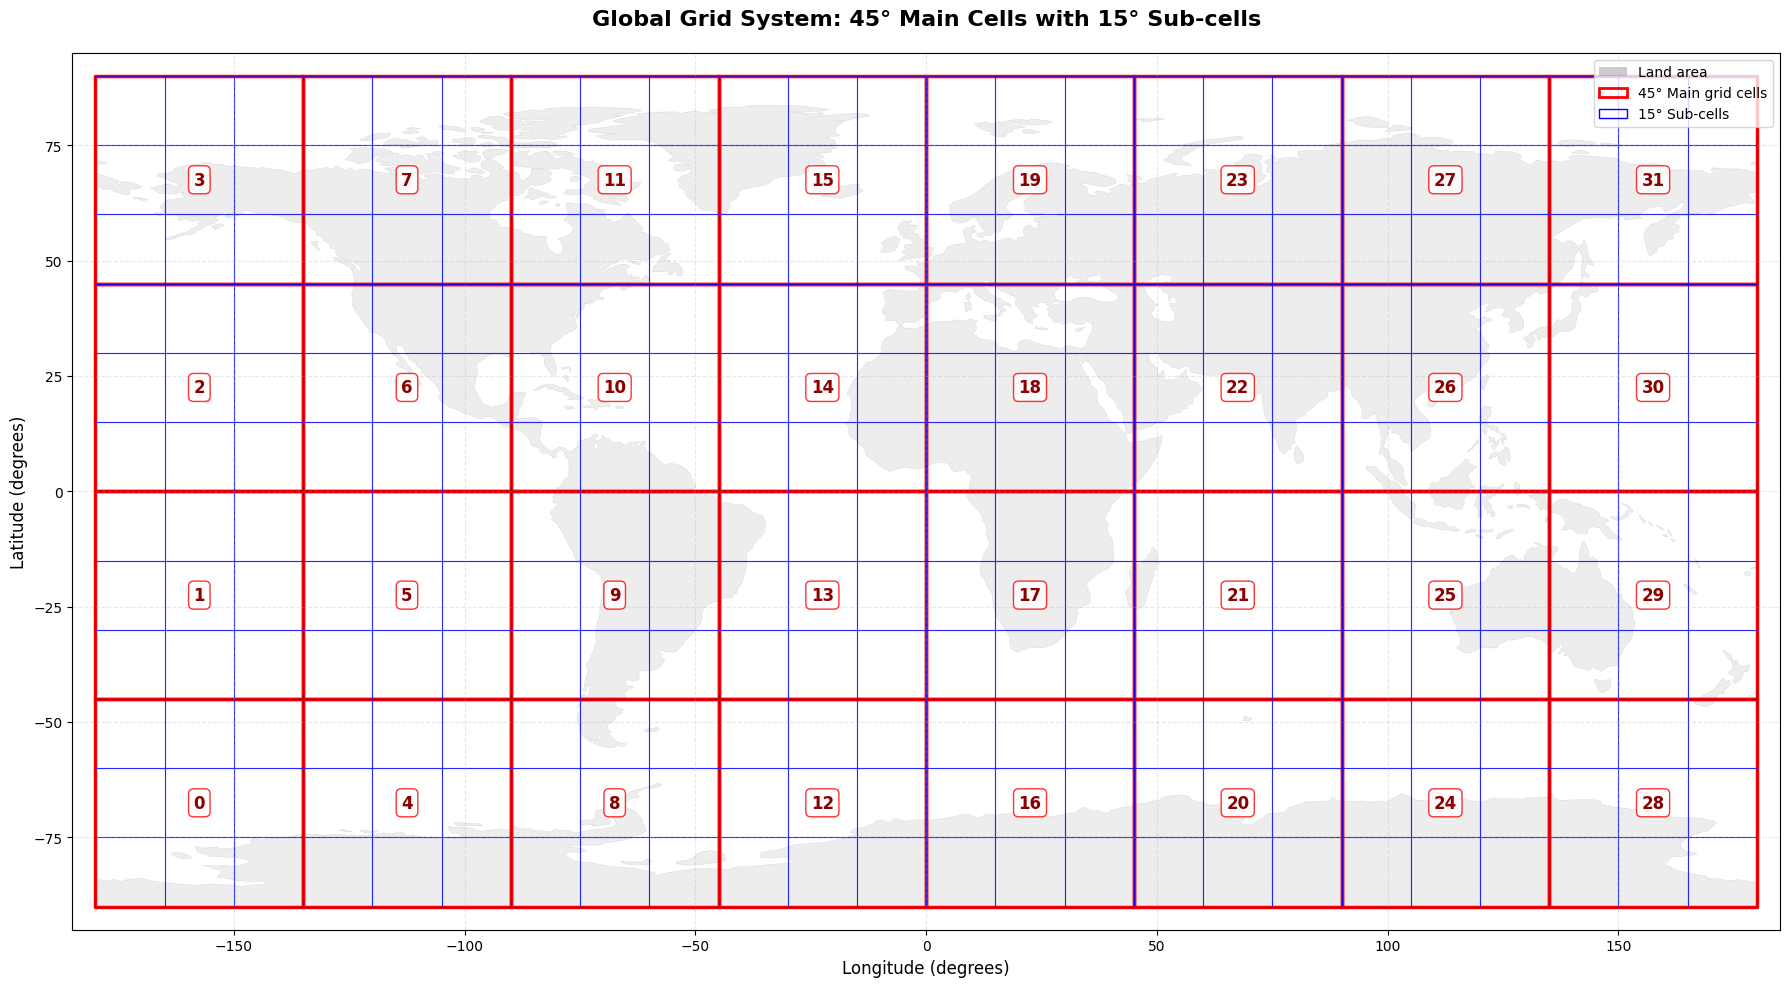

In [15]:
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Create GeoDataFrames for visualization
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=["geometry", "label"], crs="EPSG:4326")

# Create GeoDataFrame for sub-cells (for visualization)
sub_cell_data = []
for grid_index, sub_cells in grid_subcells.items():
    for i, sub_cell in enumerate(sub_cells):
        sub_cell_data.append((sub_cell, f"{grid_index}_{i}"))

sub_grid_gdf = gpd.GeoDataFrame(
    sub_cell_data, columns=["geometry", "label"], crs="EPSG:4326"
)

print(f"Red cells: {len(grid_gdf)} main grid cells ({MAIN_CELL_SIZE}° each)")
print(f"Blue cells: {len(sub_grid_gdf)} sub-cells ({SUB_CELL_SIZE}° each)")


# Get world boundaries using cartopy
def get_world_boundaries():
    """Get world boundaries from cartopy"""

    # Get land geometries from cartopy
    land = cfeature.LAND.geometries()

    # Convert to GeoDataFrame
    geoms = list(land)
    world = gpd.GeoDataFrame([{"geometry": geom} for geom in geoms], crs="EPSG:4326")
    return world


# Get world boundaries
world = get_world_boundaries()

# Plot the map
fig, ax = plt.subplots(figsize=(18, 10))

# Plot world boundaries from cartopy
world.plot(ax=ax, color="lightgray", edgecolor="darkgray", alpha=0.4, linewidth=0.3)

# Plot grid
grid_gdf.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2.5)
sub_grid_gdf.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=0.8, alpha=0.6)

# Add enhanced labels to main grid cells
for idx, row in grid_gdf.iterrows():
    centroid = row.geometry.centroid

    # Add white background for better readability
    ax.text(
        centroid.x,
        centroid.y,
        row.label,
        fontsize=12,
        ha="center",
        va="center",
        color="darkred",
        weight="bold",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="red"
        ),
    )

# Enhance the plot appearance
ax.set_title(
    f"Global Grid System: {MAIN_CELL_SIZE}° Main Cells with {SUB_CELL_SIZE}° Sub-cells",
    fontsize=16,
    weight="bold",
    pad=20,
)
ax.set_xlabel("Longitude (degrees)", fontsize=12)
ax.set_ylabel("Latitude (degrees)", fontsize=12)

# Set axis limits and grid
ax.set_xlim(-185, 185)
ax.set_ylim(-95, 95)
ax.grid(True, alpha=0.3, linestyle="--")

legend_elements = [
    Patch(facecolor="gray", alpha=0.4, label="Land area"),
    Patch(
        facecolor="none",
        edgecolor="red",
        linewidth=2,
        label=f"{MAIN_CELL_SIZE}° Main grid cells",
    ),
    Patch(
        facecolor="none",
        edgecolor="blue",
        linewidth=1,
        label=f"{SUB_CELL_SIZE}° Sub-cells",
    ),
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=10)

# Improve tick formatting
ax.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()
plt.show()

## Manage jobs

### Setup functions

In [16]:
def submit_sdg_indicator_job(api_client, geojsons, task_name, job_params):
    """
    Submit an SDG 15.3.1 indicator job to the API.

    Note: This is a simplified wrapper around api_client.submit_job() with
    SDG-specific parameter formatting. The core submission logic is handled
    by the shared TrendsEarthAPIClient.

    Args:
        api_client: TrendsEarthAPIClient instance
        geojsons: List of GeoJSON geometries for the areas of interest
        task_name: Name for the submitted task
        job_params: Job parameters including baseline_period and status_periods

    Returns:
        Job ID if successful, False otherwise
    """
    if not api_client.access_token or not job_params:
        print("Missing authentication token or job parameters")
        return False

    # Prepare job parameters specific to SDG indicator jobs
    params = {
        "geojsons": geojsons,
        "baseline_period": job_params["baseline_period"],
        "status_periods": job_params["status_periods"],
        "script": job_params["baseline_period"]["script"],
        "task_name": task_name,
        "task_notes": job_params["baseline_period"].get("task_notes", ""),
        "filetype": job_params["baseline_period"].get("filetype", "tif"),
        "crosses_180th": job_params["baseline_period"].get("crosses_180th", False),
        "crs": job_params["baseline_period"].get("crs", "EPSG:4326"),
    }

    # Submit using the generic submit_job method from TrendsEarthAPIClient
    job_id = api_client.submit_job("sdg-15-3-1-indicator-2-1-20", params)
    return job_id


print("SDG indicator job submission function ready (using shared API client)")

SDG indicator job submission function ready (using shared API client)


### Submit Jobs for Grid Cells

Submit jobs for selected grid cells. Each job contains all 15-degree sub-cells within a each main cell.

In [22]:
# Select which grid cells to process
grid_indices = list(range(0, len(grid_cells)))
# grid_indices = list(range(0, len(grid_cells)-16))
grid_indices = [30]

PRODUCTIVITY_MODE = "TE"
# PRODUCTIVITY_MODE = "JRC"
# PRODUCTIVITY_MODE = "FAO-WOCAT"
SUBMIT_JOBS = True  # Set to False to just show what would be submitted
PAUSE_BETWEEN_JOBS = True  # Add random delay between submissions

submitted_jobs = []

job_params = load_job_parameters(PRODUCTIVITY_MODE)

if api_client.access_token and job_params:
    print(f"Starting job submission for {len(grid_indices)} grid cells...")

    for i, grid_index in enumerate(grid_indices):
        # Get the 15-degree sub-cells for this 60-degree grid cell
        sub_cells = grid_subcells[grid_index]

        # Convert to geojson format
        sub_cell_geojsons = convert_subcells_to_geojson(sub_cells)

        # Create task name
        task_name = f"sdg_indicator-{MAIN_CELL_SIZE}deg_cell_{grid_index}_with_{len(sub_cell_geojsons)}_subcells_{PRODUCTIVITY_MODE}"

        print(f"\nJob {i + 1}/{len(grid_indices)}: Grid cell {grid_index}")
        print(f"   Task name: {task_name}")
        print(f"   Sub-cells: {len(sub_cell_geojsons)} × {SUB_CELL_SIZE}°")
        print(f"   Productivity mode: {PRODUCTIVITY_MODE}")

        if SUBMIT_JOBS:
            # Submit the job using the local function
            job_id = submit_sdg_indicator_job(
                api_client, sub_cell_geojsons, task_name, job_params
            )

            if job_id:
                submitted_jobs.append(
                    {
                        "grid_index": grid_index,
                        "task_name": task_name,
                        "producivity_mode": PRODUCTIVITY_MODE,
                        "job_id": job_id,
                        "sub_cells_count": len(sub_cell_geojsons),
                    }
                )

            # Add delay between jobs to avoid overwhelming the server
            if PAUSE_BETWEEN_JOBS and i < len(grid_indices) - 1:
                sleep_time = np.abs(np.random.normal(30, 15))  # 30±15 seconds
                print(f"   ⏱Waiting {sleep_time:.0f} seconds before next submission...")
                time.sleep(sleep_time)
        else:
            print(
                f"   ℹ[DRY RUN] Would submit job with {len(sub_cell_geojsons)} sub-cells"
            )

    if SUBMIT_JOBS:
        print("\nJob submission complete!")
        print(f"Successfully submitted: {len(submitted_jobs)}/{len(grid_indices)} jobs")

        if submitted_jobs:
            print("\n📋 Submitted job summary:")
            for job in submitted_jobs:
                print(
                    f"   Grid {job['grid_index']}: {job['job_id']} ({job['sub_cells_count']} sub-cells)"
                )
    else:
        print("\nDry run complete - no jobs were actually submitted")

else:
    print("Cannot submit jobs: missing authentication token or job parameters")

Loading parameters for productivity mode: TE
Updated baseline with TE productivity parameters
Updated reporting_1 with TE productivity parameters
Updated reporting_2 with TE productivity parameters
Job parameters loaded successfully with TE productivity
Productivity mode: TrendsEarth-LPD-5
Reporting periods: 2
Starting job submission for 1 grid cells...

Job 1/1: Grid cell 30
   Task name: sdg_indicator-60deg_cell_30_with_9_subcells_TE
   Sub-cells: 9 × 15°
   Productivity mode: TE


2025-11-02 14:31:36.134 INFO: Job submitted successfully (ID: 06d455f9-f8f8-47ad-85f6-3619dec71924)



Job submission complete!
Successfully submitted: 1/1 jobs

📋 Submitted job summary:
   Grid 30: 06d455f9-f8f8-47ad-85f6-3619dec71924 (9 sub-cells)


### Check Job Status

Monitor the status of submitted jobs

In [23]:
# Get grid cell jobs
print("Fetching grid cell jobs...")

PRODUCTIVITY_MODE = "TE"
# PRODUCTIVITY_MODE = "JRC"
# PRODUCTIVITY_MODE = "FAO-WOCAT"

# Get our specific jobs (grid cell jobs) using the grid-specific filter
# Now filters by productivity mode as well
grid_jobs = api_client.get_jobs_filtered_by_grid_cells(
    filter_name=f"{MAIN_CELL_SIZE}deg_cell_",
    days_back=NUM_DAYS,
    productivity_mode=PRODUCTIVITY_MODE,
)
grid_jobs = api_client.get_jobs_filtered_by_grid_cells(
    filter_name="60deg_cell_", days_back=NUM_DAYS, productivity_mode=PRODUCTIVITY_MODE
)

print(
    f"Found {len(grid_jobs)} grid cell jobs for productivity mode: {PRODUCTIVITY_MODE}"
)

# Print grid cell job details using shared functions
if grid_jobs:
    print_job_details(grid_jobs, max_jobs=32, local_tz=LOCAL_TZ)

    # Store for download later
    jobs = grid_jobs
else:
    print(f"📭 No grid cell jobs found for productivity mode: {PRODUCTIVITY_MODE}")
    jobs = []

print("\nJob status check complete")

Fetching grid cell jobs...
Access token expired, attempting to refresh...
Refreshing access token...


2025-11-02 15:23:29.495 INFO: Successfully refreshed access token


Successfully refreshed access token
Filtered to 32 most recent jobs from 125 total grid cell jobs for productivity mode 'TE'
Found 32 grid cell jobs for productivity mode: TE

Job Details (showing up to 32):
    1. sdg_indicator-60deg_cell_0_wit | FINISHED   | Oct 31 - 07:26 PM → Oct 31 - 09:11 PM
    2. sdg_indicator-60deg_cell_1_wit | FINISHED   | Oct 27 - 08:39 PM → Oct 28 - 12:00 AM
    3. sdg_indicator-60deg_cell_2_wit | FINISHED   | Oct 28 - 01:13 PM → Oct 28 - 06:19 PM
    4. sdg_indicator-60deg_cell_3_wit | FINISHED   | Oct 27 - 08:40 PM → Oct 27 - 11:20 PM
    5. sdg_indicator-60deg_cell_4_wit | FINISHED   | Oct 31 - 09:12 PM → Oct 31 - 10:56 PM
    6. sdg_indicator-60deg_cell_5_wit | FINISHED   | Oct 27 - 08:41 PM → Oct 28 - 12:47 AM
    7. sdg_indicator-60deg_cell_6_wit | FINISHED   | Oct 27 - 08:41 PM → Oct 28 - 01:39 AM
    8. sdg_indicator-60deg_cell_7_wit | FINISHED   | Oct 27 - 08:42 PM → Oct 28 - 05:21 AM
    9. sdg_indicator-60deg_cell_8_wit | FINISHED   | Oct 27 - 08

### Download Jobs

In [29]:
# Create productivity mode specific download directory
productivity_download_dir = DOWNLOAD_DIR / PRODUCTIVITY_MODE
if not productivity_download_dir.exists():
    productivity_download_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {productivity_download_dir}")
else:
    print(f"Using directory: {productivity_download_dir}")

# Get finished jobs that match the current productivity mode
if "jobs" in locals() and jobs:
    # Filter jobs to only include those matching the current PRODUCTIVITY_MODE
    finished_jobs = []
    for job in jobs:
        if job.get("status") == "FINISHED":
            task_name = job.get("params", {}).get("task_name", "")
            if task_name.endswith(f"_subcells_{PRODUCTIVITY_MODE}"):
                finished_jobs.append(job)

    print(f"Found {len(finished_jobs)} finished jobs for {PRODUCTIVITY_MODE}")

    if finished_jobs:
        downloaded_files = []
        tiff_files = []

        for i, job in enumerate(finished_jobs):
            task_name = job.get("params", {}).get("task_name", "unknown")
            job_id = job.get("id", "unknown")

            grid_match = re.search(r"60deg_cell_(\d+)_with", task_name)
            if grid_match:
                grid_cell = grid_match.group(1)
                print(grid_cell)
                if grid_cell not in ["16"]:
                    continue

            print(f"Job {i + 1}/{len(finished_jobs)}: {task_name}")

            try:
                # Download directly into productivity mode directory (all jobs in same folder)
                # The API client handles metadata saving with standardized naming via the subclass
                job_download_dir = api_client.download_job(
                    job, productivity_download_dir
                )

                # If API client returns None, use the productivity mode directory directly
                if job_download_dir is None:
                    print("  API download failed")

                elif job_download_dir and job_download_dir.exists():
                    print(f"  Using directory: {job_download_dir}")

                    # Get downloaded files from the directory
                    job_downloaded_files = list(job_download_dir.glob("*"))
                    downloaded_files.extend(job_downloaded_files)

                    # Add to TIFF files list
                    _, downloaded_tiffs = get_tiff_files(job_downloaded_files)
                    if downloaded_tiffs:
                        tiff_files.extend(downloaded_tiffs)
                        print(f"  Found {len(downloaded_tiffs)} TIFF files")
                    else:
                        print("  No TIFF files found yet")

                else:
                    print("  Failed to access download directory")

            except Exception as download_error:
                print(f"  Download error: {str(download_error)}")

        print(
            f"\nDownload complete: {len(downloaded_files)} files, {len(tiff_files)} TIFF files"
        )
        print(f"Location: {productivity_download_dir}")

        if tiff_files:
            print("\nTIFF files:")
            for tiff in tiff_files[:5]:
                print(f"  {tiff.name}")
            if len(tiff_files) > 5:
                print(f"  ... and {len(tiff_files) - 5} more")

    else:
        print(f"No finished jobs available for {PRODUCTIVITY_MODE}")
else:
    print("No jobs available - run job status check first")

Using directory: C:\Data\TrendsEarth_Global_Data_Tiles\TE
Found 32 finished jobs for TE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Job 17/32: sdg_indicator-60deg_cell_16_with_9_subcells_TE
Found 1 raster datasets
Processing raster: Int16
  Found 9 tiles
    Downloading: https://www.googleapis.com/download/storage/v1/b/ldmt/o/56775d26-b5e7-4a82-8134-09e9fb2b2385_sdg_indicator_Int16_1.tif?generation=1762104422258369&alt=media
    Downloaded: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-16-TE-Int16_1.tif
    Downloading: https://www.googleapis.com/download/storage/v1/b/ldmt/o/56775d26-b5e7-4a82-8134-09e9fb2b2385_sdg_indicator_Int16_2.tif?generation=1762104428569553&alt=media
    Downloaded: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-16-TE-Int16_2.tif
    Downloading: https://www.googleapis.com/download/storage/v1/b/ldmt/o/56775d26-b5e7-4a82-8134-09e9fb2b2385_sdg_indicator_Int16_3.tif?generation=1762104423687348&alt=media
    Downloaded: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-16-TE-Int16_3

## Create mosaic

### Setup functions

In [30]:
# Add OSGeo4W GDAL tools to PATH
osgeo_bin = r"C:\OSGeo4W\bin"
if Path(osgeo_bin).exists():
    current_path = os.environ.get("PATH", "")
    if osgeo_bin not in current_path:
        os.environ["PATH"] = f"{osgeo_bin};{current_path}"
        print(f"Added {osgeo_bin} to PATH")
    else:
        print(f"{osgeo_bin} already in PATH")
else:
    print(f" Warning: {osgeo_bin} not found. Please install OSGeo4W or GDAL")

# Verify GDAL tools are available
try:
    result = subprocess.run(
        ["gdalbuildvrt", "--help"], capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        print("gdalbuildvrt is available")
    else:
        print("gdalbuildvrt failed")
except FileNotFoundError:
    print("gdalbuildvrt not found in PATH")
except Exception as e:
    print(f"Error checking gdalbuildvrt: {e}")

try:
    result = subprocess.run(
        ["gdal_translate", "--help"], capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        print("gdal_translate is available")
    else:
        print("gdal_translate failed")
except FileNotFoundError:
    print("gdal_translate not found in PATH")
except Exception as e:
    print(f"Error checking gdal_translate: {e}")


def add_band_descriptions_to_vrt(vrt_path, productivity_mode):
    """
    Add band description metadata to VRT file

    Args:
        vrt_path: Path to the VRT file
        productivity_mode: Productivity mode ("TE", "FAO-WOCAT", "JRC")
    """
    # Define productivity method text based on mode
    prod_method = {"TE": "Trends.Earth", "FAO-WOCAT": "FAO-WOCAT", "JRC": "JRC"}.get(
        productivity_mode
    )

    # Band descriptions
    band_descriptions = [
        "SDG Indicator 15.3.1 for baseline (2000-2015)",
        f"Land Productivity Dynamics (using {prod_method}) for 2001 - 2015",
        "Land cover degradation for 2000 - 2015",
        "Soil organic carbon degradation for 2000 - 2015",
        "SDG Indicator 15.3.1 for 2004-2019",
        f"Land Productivity Dynamics (using {prod_method}) for 2004 - 2019",
        "Land cover degradation for 2015 - 2019",
        "Soil organic carbon degradation for 2015 - 2019",
        "SDG Indicator 15.3.1 status in 2019 (compared to 2000-2015 baseline)",
        "SDG Indicator 15.3.1 for 2008-2023",
        f"Land Productivity Dynamics (using {prod_method}) for 2008-2023",
        "Land cover degradation for 2015 - 2023",
        "Soil organic carbon degradation for 2015 - 2023",
        "SDG Indicator 15.3.1 status in 2023 (compared to 2000-2015 baseline)",
    ]

    try:
        # Parse VRT file
        tree = ET.parse(vrt_path)
        root = tree.getroot()

        # Find all VRTRasterBand elements
        bands = root.findall(".//VRTRasterBand")

        if len(bands) != len(band_descriptions):
            print(
                f" Warning: Found {len(bands)} bands but have {len(band_descriptions)} descriptions"
            )

        # Add description to each band
        for i, band in enumerate(bands):
            if i < len(band_descriptions):
                # Remove existing Description element if present
                for desc in band.findall("Description"):
                    band.remove(desc)

                # Add new Description element
                desc_elem = ET.SubElement(band, "Description")
                desc_elem.text = band_descriptions[i]

        # Write modified VRT
        tree.write(vrt_path, encoding="utf-8", xml_declaration=True)
        print(f"Added band descriptions to VRT ({len(bands)} bands)")

    except Exception as e:
        print(f"Error adding band descriptions: {e}")

C:\OSGeo4W\bin already in PATH
gdalbuildvrt is available
gdal_translate is available


### Make mosaic

In [ ]:
import time
from datetime import datetime

PRODUCTIVITY_MODE = "TE"
# PRODUCTIVITY_MODE = "JRC"
# PRODUCTIVITY_MODE = "FAO-WOCAT"

productivity_download_dir = DOWNLOAD_DIR / PRODUCTIVITY_MODE

start_time = datetime.now()
start_perf = time.perf_counter()
print(f"Start time: {start_time:%Y-%m-%d %H:%M:%S}")

tiff_pattern = f"TrendsEarth_SDG15.3.1_*-{PRODUCTIVITY_MODE}-*.tif"
tiff_files = sorted(productivity_download_dir.glob(tiff_pattern))
print(f"Found {len(tiff_files)} TIFFs for {PRODUCTIVITY_MODE}")

if not tiff_files:
    raise ValueError(f"No TIFF files found matching pattern: {tiff_pattern}")

# Create output mosaic filename
output_mosaic = (
    productivity_download_dir
    / f"TrendsEarth_SDG15.3.1_2000_2023_{PRODUCTIVITY_MODE}.tif"
)
vrt_file = (
    productivity_download_dir
    / f"TrendsEarth_SDG15.3.1_2000_2023_{PRODUCTIVITY_MODE}_temp_mosaic.vrt"
)
file_list = (
    productivity_download_dir
    / f"TrendsEarth_SDG15.3.1_2000_2023_{PRODUCTIVITY_MODE}_tiff_files.txt"
)

# Get optimal settings
cpu_count = multiprocessing.cpu_count()
warp_threads = max(1, cpu_count - 1)
cache_mb = 4096

print(f"Using {warp_threads} threads, {cache_mb}MB cache")

# Write file list
with open(file_list, "w") as f:
    for tiff in tiff_files:
        f.write(f"{tiff}\n")

# Build VRT using file list
gdalbuildvrt = str(Path(osgeo_bin) / "gdalbuildvrt.exe")
print("Building VRT...")
subprocess.run(
    [gdalbuildvrt, "-input_file_list", str(file_list), str(vrt_file)], check=True
)

# Add band descriptions to VRT
add_band_descriptions_to_vrt(vrt_file, PRODUCTIVITY_MODE)

# Create COG with optimizations
gdal_translate = str(Path(osgeo_bin) / "gdal_translate.exe")
print("Creating COG mosaic...")
subprocess.run(
    [
        gdal_translate,
        "-of",
        "COG",
        "-a_nodata",
        "-32768",
        "-co",
        "COMPRESS=LZW",
        "-co",
        "PREDICTOR=2",
        "-co",
        "NUM_THREADS=ALL_CPUS",
        "-co",
        "INTERLEAVE=BAND",
        "-co",
        "BIGTIFF=YES",
        "--config",
        "GDAL_CACHEMAX",
        str(cache_mb),
        "--config",
        "GDAL_NUM_THREADS",
        str(warp_threads),
        str(vrt_file),
        str(output_mosaic),
    ],
    check=True,
)

# Cleanup
vrt_file.unlink()
file_list.unlink()
print(f"Mosaic created: {output_mosaic}")

end_time = datetime.now()
elapsed_seconds = time.perf_counter() - start_perf
print(f"End time: {end_time:%Y-%m-%d %H:%M:%S}")
print(f"Total time: {elapsed_seconds / (60 * 60):.2f} hours")

Start time: 2025-11-02 15:59:03
Found 288 TIFFs for TE
Using 19 threads, 4096MB cache
Building VRT...
Added band descriptions to VRT (14 bands)
Creating COG mosaic...
Mosaic created: C:\Data\TrendsEarth_Global_Data_Tiles\TE\TrendsEarth_SDG15.3.1_2000_2023_TE.tif
End time: 2025-11-03 04:50:15
Total time: 12.85 hours


## Upload final mosaic and tiles to Google Cloud Storage

If the below returns an error like:

```
Not signed up for Earth Engine or project is not registered. Visit https://developers.google.com/earth-engine/guides/access
```

Try running `earthengine authenticate`, and then `earthengine set_project gef-land-degradation`.

In [57]:
# PRODUCTIVITY_MODE = "Trends.Earth"
PRODUCTIVITY_MODE = "JRC"
# PRODUCTIVITY_MODE = "FAO-WOCAT"

MOSAIC_DIR = Path("C:/Data/Output")
MOSAIC = Path(f"TrendsEarth_SDG15.3.1_2000-2023_{PRODUCTIVITY_MODE}.tif")
ASSET_NAME = MOSAIC.stem.replace(".", "-")
# Configure these values for the COG you want to promote to Earth Engine.
gcs_cog_uri = f"gs://trendsearth-public/unccd_reporting/2016-2023/{MOSAIC}"
asset_id = f"projects/gef-land-degradation/assets/{ASSET_NAME}"
manifest_path = Path(MOSAIC_DIR / (MOSAIC.stem + "_GEE-manifest.json"))


class BandMetadata(TypedDict):
    id: str
    description: str
    start_time: Optional[str]
    end_time: Optional[str]


class BandTimeRange(TypedDict, total=False):
    start_time: Optional[str]
    end_time: Optional[str]


def iso_to_millis(iso_string: Optional[str]) -> Optional[int]:
    """Convert an ISO-8601 timestamp to milliseconds since epoch for Earth Engine."""
    if not iso_string:
        return None
    dt = datetime.fromisoformat(iso_string.replace("Z", "+00:00"))
    return int(dt.timestamp() * 1000)


def make_band_id(description: str) -> str:
    """Create a stable Earth Engine band ID derived from the band description."""
    slug = re.sub(r"[^0-9a-zA-Z]+", "_", description).strip("_").lower()
    slug = re.sub(r"_+", "_", slug)
    return f"{slug}"[:80]


def build_band_descriptions(productivity_mode: str) -> List[str]:
    return [
        "SDG Indicator 15.3.1 for baseline (2000-2015)",
        f"Land Productivity Dynamics (using {productivity_mode}) for 2001 - 2015",
        "Land cover degradation for 2000 - 2015",
        "Soil organic carbon degradation for 2000 - 2015",
        "SDG Indicator 15.3.1 for 2004-2019",
        f"Land Productivity Dynamics (using {productivity_mode}) for 2004 - 2019",
        "Land cover degradation for 2015 - 2019",
        "Soil organic carbon degradation for 2015 - 2019",
        "SDG Indicator 15.3.1 status in 2019 (compared to 2000-2015 baseline)",
        "SDG Indicator 15.3.1 for 2008-2023",
        f"Land Productivity Dynamics (using {productivity_mode}) for 2008-2023",
        "Land cover degradation for 2015 - 2023",
        "Soil organic carbon degradation for 2015 - 2023",
        "SDG Indicator 15.3.1 status in 2023 (compared to 2000-2015 baseline)",
    ]


band_descriptions = build_band_descriptions(PRODUCTIVITY_MODE)
# Below is commented out as GEE doesn't support specifying start and end times per band
# for image uploads
# band_time_ranges: List[BandTimeRange] = [
#    {"start_time": "2000-01-01T00:00:00Z", "end_time": "2015-12-31T23:59:59Z"},
#    {"start_time": "2001-01-01T00:00:00Z", "end_time": "2015-12-31T23:59:59Z"},
#    {"start_time": "2000-01-01T00:00:00Z", "end_time": "2015-12-31T23:59:59Z"},
#    {"start_time": "2000-01-01T00:00:00Z", "end_time": "2015-12-31T23:59:59Z"},
#    {"start_time": "2004-01-01T00:00:00Z", "end_time": "2019-12-31T23:59:59Z"},
#    {"start_time": "2004-01-01T00:00:00Z", "end_time": "2019-12-31T23:59:59Z"},
#    {"start_time": "2015-01-01T00:00:00Z", "end_time": "2019-12-31T23:59:59Z"},
#    {"start_time": "2015-01-01T00:00:00Z", "end_time": "2019-12-31T23:59:59Z"},
#    {"start_time": "2001-01-01T00:00:00Z", "end_time": "2019-12-31T23:59:59Z"},
#    {"start_time": "2008-01-01T00:00:00Z", "end_time": "2023-12-31T23:59:59Z"},
#    {"start_time": "2008-01-01T00:00:00Z", "end_time": "2023-12-31T23:59:59Z"},
#    {"start_time": "2015-01-01T00:00:00Z", "end_time": "2023-12-31T23:59:59Z"},
#    {"start_time": "2015-01-01T00:00:00Z", "end_time": "2023-12-31T23:59:59Z"},
#    {"start_time": "2000-01-01T00:00:00Z", "end_time": "2023-12-31T23:59:59Z"},
# ]

bands: List[BandMetadata] = []
for idx, description in enumerate(band_descriptions):
    band_id = make_band_id(description)
    time_window = band_time_ranges[idx] if idx < len(band_time_ranges) else {}
    bands.append(
        {
            "id": band_id,
            "description": description,
            "start_time": time_window.get("start_time"),
            "end_time": time_window.get("end_time"),
        }
    )

manifest = {
    "name": asset_id,
    "tilesets": [
        {
            "id": "0",
            "sources": [
                {
                    "uris": [gcs_cog_uri],
                }
            ],
        }
    ],
    "properties": {"version": "1.3"},
    "startTime": "2000-01-01T00:00:00.000000000Z",
    "endTime": "2023-12-31T23:59:59.999999999Z",
    "bands": [
        {
            "id": band["id"],
            "tilesetId": "0",
            "tileset_band_index": idx,
            "missingData": {"values": [-32768]},
        }
        for idx, band in enumerate(bands)
    ],
}

manifest_path.write_text(json.dumps(manifest, indent=2))
print(f"Wrote manifest to {manifest_path}")

result = subprocess.run(["earthengine", "set_project", "gef-land-degradation"])
print(result.stdout)
if result.stderr:
    print(result.stderr)

upload_command = [
    "earthengine",
    "upload",
    "image",
    "--manifest",
    str(manifest_path),
]
print("Executing:", " ".join(upload_command))

result = subprocess.run(upload_command, check=True, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(result.stderr)

Wrote manifest to C:\Data\Output\TrendsEarth_SDG15.3.1_2000-2023_JRC_GEE-manifest.json
None
Executing: earthengine upload image --manifest C:\Data\Output\TrendsEarth_SDG15.3.1_2000-2023_JRC_GEE-manifest.json
Started upload task with ID: MGQCTAPI22Y6MYTTYRFNVQ3J

